In [7]:
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
import math
import numpy as np
from typing import List, Optional
from tqdm import tqdm

In [8]:
def plot_series(ys, color = "b"):
    xs = np.arange(ys.shape[0]) * np.ones_like(ys)

    plt.plot(xs, ys, color)
    plt.show()
    plt.close()

### Python Data Generators and some example plots

Abstract base class "Function" for all functions

In [9]:
class Function(ABC):
    @abstractmethod
    def eval(self, x: float) -> float:
        """Evaluate the function at the given x value."""
        pass
    
    def generateN(self, N):
        res = np.zeros(N)
        for i in range(N):  # Loop from 0 to N-1
            res[i]=self.eval(i)
        return res

Puls train

In [10]:
# class PulseTrain(Function):
#     def __init__(self, T=7.0 * 24, tau=2.0 * 24, phase=-24.0, c=1.0, iterations=1000):
#         self.T = T  # period, default 7 days (in hours)
#         self.tau = tau  # pulse, default 2 days (in hours)
#         self.phase = phase  # phase shift, default -tau / 2
#         self.c = c  # constant factor, default 1
#         self.iterations = iterations  # number of iterations, default 1000
#         self.factors = []  # list to store factors

#         # Compute and store factors
#         for i in range(self.iterations):
#             n = i + 1
#             factor = 2.0 * math.sin(math.pi * n * self.tau / self.T) / (math.pi * n)
#             self.factors.append(factor)

#     def eval(self, x):
#         res = self.tau / self.T
#         for i in range(self.iterations):
#             n = i + 1
#             res += self.factors[i] * math.cos((x + self.phase) * 2 * math.pi * n / self.T)
#         return self.c * res #+ self.c
class PulseTrain(Function):
    def __init__(self, T=7.0 * 24, tau=2.0 * 24, phase=-24.0, c=1.0, iterations=1000):
        self.T = T  # period, default 7 days (in hours)
        self.tau = tau  # pulse, default 2 days (in hours)
        self.phase = phase  # phase shift, default -tau / 2
        self.c = c  # constant factor, default 1
        self.iterations = iterations  # number of iterations, default 1000
        
        # Create an array of n values from 1 to iterations
        n = np.arange(1, iterations + 1)
        
        # Compute the factors vectorized
        self.factors = 2.0 * np.sin(np.pi * n * self.tau / self.T) / (np.pi * n)

    def eval(self, x):
        # Convert x to a NumPy array if it's not already (to handle scalar or array inputs)
        x = np.asarray(x)

        # Start with the first term: tau / T
        res = self.tau / self.T
        
        # Create an array of n values from 1 to iterations
        n = np.arange(1, self.iterations + 1)
        
        # Compute the cosine terms using broadcasting
        cos_terms = np.cos((x[..., np.newaxis] + self.phase) * 2 * np.pi * n / self.T)
        
        # Sum the product of factors and cosine terms along the n-axis
        res += np.sum(self.factors * cos_terms, axis=-1)

        # Return the result scaled by the constant factor c
        return self.c * res

In [11]:
N = 1000

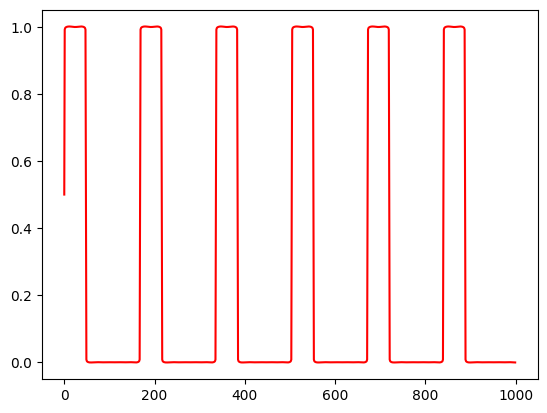

In [12]:
p = PulseTrain()  # Create an instance of PulseTrain class
yss = p.generateN(N)
plot_series(yss, "r")

Saw tooth 

In [13]:
# class Sawtooth(Function):
#     def __init__(self, T=7.0 * 24, phase=0.0, c=1.0, iterations=1000):
#         self.T = T  # period, default 7 days (in hours)
#         self.phase = phase  # phase shift, default 0
#         self.c = c  # constant factor, default 1
#         self.iterations = iterations  # number of iterations
#         self.factors = []  # list to store factors

#         # Compute and store factors
#         z = -1  # Start z with -1
#         for i in range(self.iterations):
#             n = i + 1
#             factor = z / n
#             self.factors.append(factor)
#             z *= -1  # Flip z between -1 and 1

#     def eval(self, x):
#         res = 0.0
#         for i in range(self.iterations):
#             n = i + 1
#             res += self.factors[i] * math.sin((x + self.phase) * n * 2 * math.pi / self.T)
#         return self.c * (2 / math.pi) * res 

import numpy as np

class Sawtooth(Function):
    def __init__(self, T=7.0 * 24, phase=0.0, c=1.0, iterations=1000):
        self.T = T  # period, default 7 days (in hours)
        self.phase = phase  # phase shift, default 0
        self.c = c  # constant factor, default 1
        self.iterations = iterations  # number of iterations
        
        # Create an array of n values from 1 to iterations
        n = np.arange(1, iterations + 1)
        
        # Compute the factors alternating between -1 and 1, divided by n
        z = (-1) ** (n + 1)  # Generates -1 for odd and 1 for even n
        self.factors = z / n

    def eval(self, x):
        # Convert x to a NumPy array if it's not already (to handle scalar or array inputs)
        x = np.asarray(x)
        
        # Create an array of n values from 1 to iterations
        n = np.arange(1, self.iterations + 1)
        
        # Compute the sine terms using broadcasting
        sine_terms = np.sin((x[..., np.newaxis] + self.phase) * n * 2 * np.pi / self.T)
        
        # Sum the product of factors and sine terms along the n-axis
        res = np.sum(self.factors * sine_terms, axis=-1)
        
        # Return the result scaled by the constant factor c and (2 / pi)
        return (-1)*self.c * (2 / np.pi) * res


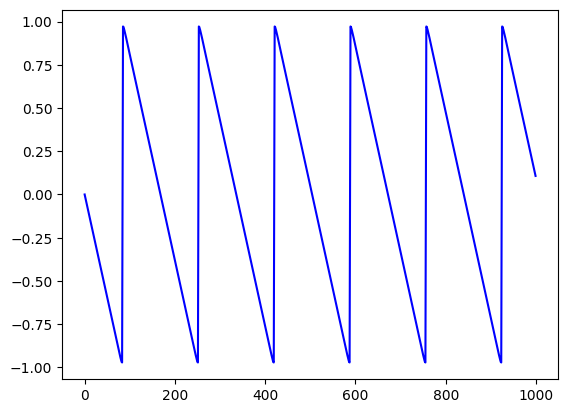

In [14]:
p = Sawtooth()  # Create an instance of Sawtooth class
yss = p.generateN(N)
plot_series(yss)

Sine

In [15]:
class Period(Function):
    def __init__(self, T=30.0 * 24, phase=0.0, c=1.0):
        self.T = T  # period, default 30 days (in hours)
        self.phase = phase  # phase shift, default 0
        self.c = c  # constant factor, default 1

    def eval(self, x):
        res = self.c * math.sin(2 * math.pi * (x + self.phase) / self.T)
        return res

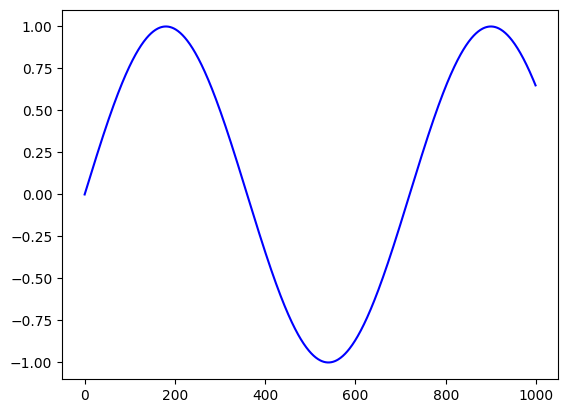

In [16]:
p = Period()  # Create an instance of Period class
yss = p.generateN(N)
plot_series(yss)

For constant offset or linear function components

In [17]:
class Line(Function):
    def __init__(self, offset=0.0, slope=1.0):
        self.offset = offset  # default offset 0
        self.slope = slope  # default slope 1

    def eval(self, x):
        return self.offset + self.slope * x

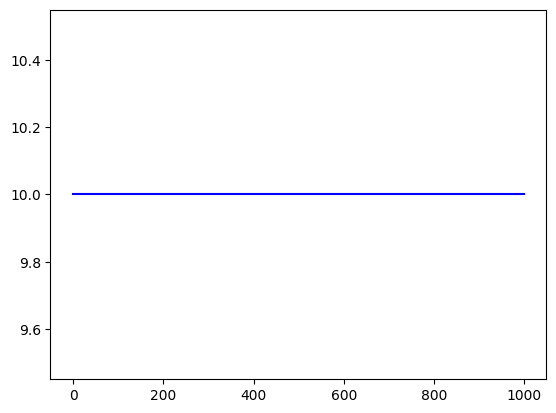

In [18]:
p = Line(10,0)  # Create an instance of Line class
yss = p.generateN(N)
plot_series(yss)

Gaussian Noise

In [19]:
class RandomNoise(Function):
    def __init__(self, mu=0.0, sigma=1.0):
        self.mu = mu  # default mu 0
        self.sigma = sigma  # default sigma 1

    def eval(self, x):
        return np.random.normal(self.mu, self.sigma, 1)
    
    def generateN(self, N):
        return np.random.normal(self.mu, self.sigma, N)

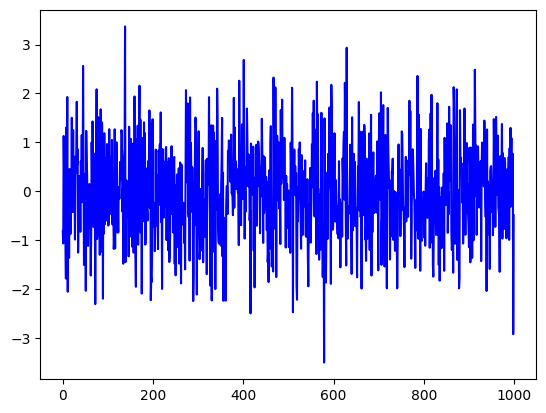

In [20]:
p = RandomNoise(0,1)  # Create an instance of Random class
yss = p.generateN(N)
plot_series(yss)

Compound functions

In [21]:
# Define the abstract class Compound that implements Function
class Compound(Function):
    def __init__(self):
        self.sub_functions: List[Function] = []  # Initialize the list to hold Function objects

    def add_function(self, f: Function):
        """Add a function to the list."""
        self.sub_functions.append(f)

In [22]:
# Define the concrete class Sum that implements Function
class Sum(Compound):
    def eval(self, x: float) -> float:
        """Evaluate the sum of all summand functions at the given x value."""
        res = 0.0
        for f in self.sub_functions:
            res += f.eval(x)
        return res

Sum: const + N(0,1) + monthly (T1=720h) sine + weekly (T2=168h) pulse + dayly (T3=24h) sine

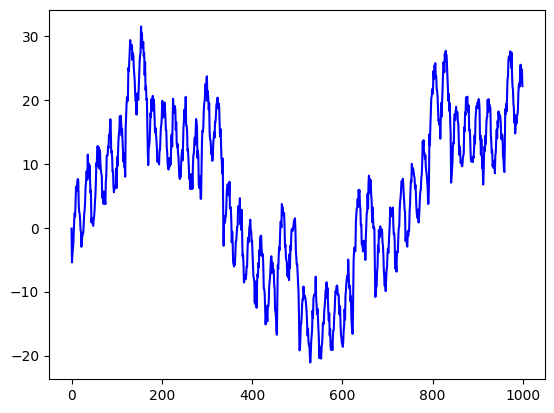

In [23]:
s = Sum()
#s.add_summand_function(Line(200, 0))  # Add a Line function with offset 200 and slope 0
s.add_function(RandomNoise(0, 1))  # Add a Random function 
# Monthly, T1=720
s.add_function(Period(30.0 * 24, 0, 15))  # Add a Period function for monthly period
# Weekly, T2=168
s.add_function(PulseTrain(7 * 24, 2 * 24, 24, 10))  # Add a PulseTrain function for weekly period
# Daily, T3=24
s.add_function(Period(24, -6, 5))  # Add a Period function for daily period

yys = s.generateN(N)
plot_series(yys)

In [24]:
# Define the concrete class Product that implements Function
class Product(Compound):
    def eval(self, x: float) -> float:
        """Evaluate the sum of all product functions at the given x value."""
        res = 1.0
        for f in self.sub_functions:
            res *= f.eval(x)
        return res

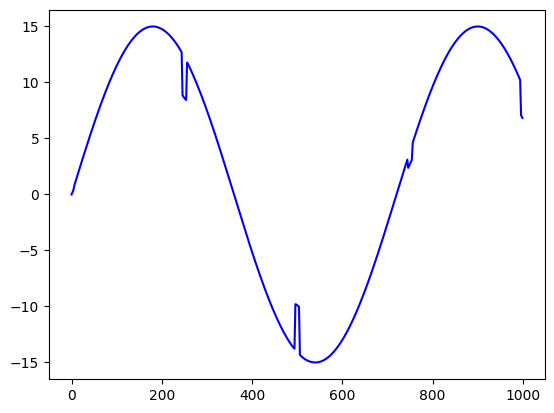

In [25]:
p = Product()
s = Sum()
s.add_function(Line(1,0))  
s.add_function(PulseTrain(T=250, tau=10, phase=0, c=-0.3))  
p.add_function(s)  
p.add_function(Period(30.0 * 24, 0, 15))  

yys = p.generateN(N)
plot_series(yys)

Filter amplitude

In [26]:
class FilterAmplitude(Function):
    def __init__(self, f: Function, lower_bound: Optional[float], upper_bound: Optional[float]):
        self.f = f
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound

    def eval(self, x: float) -> float:
        res = self.f.eval(x)
        if self.lower_bound is not None:
            res = max(res, self.lower_bound)
        if self.upper_bound is not None:
            res = min(res, self.upper_bound)
        return res


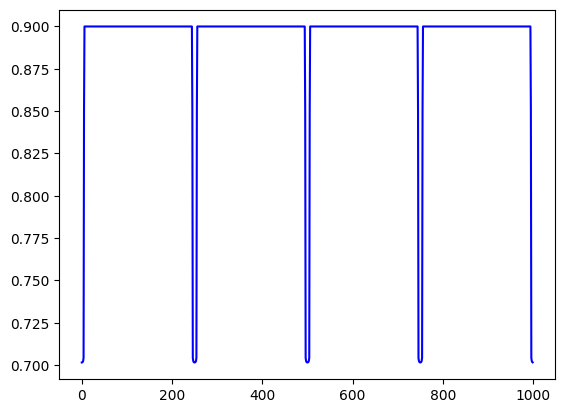

In [27]:
filtered = FilterAmplitude(s, 0, 0.9)

yss = filtered.generateN(N)
plot_series(yss)

In [28]:
class DatasetGenerator(ABC):
    @abstractmethod
    def getFunction(self, severeness: int):
        """Generates N correct data series."""
        pass

    def generateN(self, N: int, severeness: int):
        """Generates data series each with the given severeness s."""
        f = self.getFunction(severeness)
        return f.generateN(N)
    
    def generateKN(self, K, N, fraction, severeness: int, verbose: bool, name : str = ""):
        """Generates K series of length N of data with fraction outliers and a certen severeness."""
        res = np.zeros([K,N])
        xs = np.arange(N)

        color = 'r'
        for i in tqdm(range(K)): 
            if i >= K*fraction:
                color = 'b'
                severeness = 0
            ys = self.generateN(N, severeness)
            if verbose:
                plt.plot(xs, ys, color, linewidth=0.2)
            res[i]=ys
        if verbose:
            plt.show()
            plt.close()
        if name != "":
            np.save(name+".npy", res)
            labels =  np.concatenate([np.ones(int(K*fraction)), np.zeros(int(K*(1-fraction)))])
            np.save(name+"_labels.npy",labels)
            
        return res   
    
    def load(self, name : str):
        res = np.load(name+".npy")
        labels = np.load(name+"_labels.npy")
        return [res, labels]


In [29]:
class DatasetGeneratorLift(DatasetGenerator):
    """Generates data series each with the given severeness s: offset = 200 + 2*s."""
    """Outliers with offset 2*severeness"""
    def getFunction(self, severeness):
        s = Sum()
        s.add_function(Line(200+ 2*severeness, 0))  # Add a Line function with offset 200 + 2*s and slope 0
        s.add_function(RandomNoise(0, 1))  # Add a Random function 
        
        # Monthly, T1=720
        p1 = 30 + np.random.normal(0, 0.3, 1)
        a1 = 15 + np.random.normal(0, 0.3, 1)
        s.add_function(Period(p1 * 24, 0, a1))  # Add a Period function for monthly period
        
        # Weekly, T2=168
        p2 = 7 + np.random.normal(0, 0.2, 1)
        a2 = 10 + np.random.normal(0, 0.2, 1)
        s.add_function(PulseTrain(p2 * 24, 2 * 24, 24, a2))  # Add a PulseTrain function for weekly period

        # Daily, T3=24
        p3 = 1 + np.random.normal(0, 0.1, 1)
        a3 = 5 + np.random.normal(0, 0.1, 1)
        s.add_function(Period(p3 * 24, -6, a3))  # Add a Period function for daily period
        return s

In [30]:
dg = DatasetGeneratorLift()
#10 data series a 1000 points with 20% outliers of severeness degree 2 (red), i.e., noise ~ N(0,1+2) instead of N(0,1)
anomaly_ratio = 0.05
n_sines = 10000
testCase0 = dg.generateKN(n_sines, 500, anomaly_ratio, severeness=2, verbose = False, name ="testCase0")

100%|█████████████████████████████████████| 10000/10000 [06:14<00:00, 26.71it/s]


In [52]:
dg = DatasetGeneratorLift()
res, labels = dg.load("testCase0")

In [27]:
class DatasetGeneratorNoise(DatasetGenerator):
    """Generates data series each with the given severeness s: noise ~ N(0,1+s)."""
    def getFunction(self, severeness):
        s = Sum()
        s.add_function(Line(200, 0))  # Add a Line function with offset 200 and slope 0
        s.add_function(RandomNoise(0, 1 + severeness))  # Add a Random function 
        
        # Monthly, T1=720
        p1 = 30 + np.random.normal(0, 2, 1)
        a1 = 15 + np.random.normal(0, 2, 1)
        s.add_function(Period(p1 * 24, 0, a1))  # Add a Period function for monthly period
        
        # Weekly, T2=168
        p2 = 7 + np.random.normal(0, 1, 1)
        a2 = 10 + np.random.normal(0, 1, 1)
        s.add_function(PulseTrain(p2 * 24, 2 * 24, 24, a2))  # Add a PulseTrain function for weekly period

        # Daily, T3=24
        p3 = 1 + np.random.normal(0, 0.1, 1)
        a3 = 5 + np.random.normal(0, 0.1, 1)
        s.add_function(Period(p3 * 24, -6, a3))  # Add a Period function for daily period
        return s

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.82it/s]


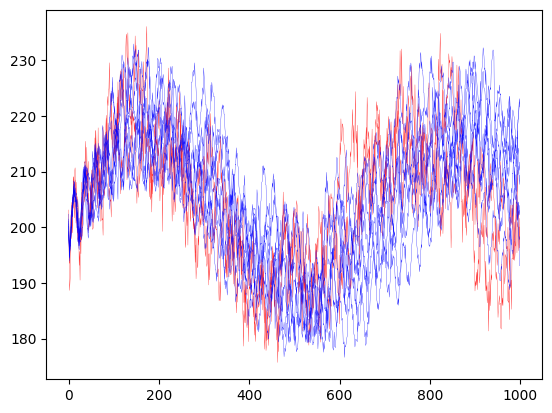

In [28]:
dg = DatasetGeneratorNoise()
#10 data series a 1000 points with 20% outliers of severeness degree 2 (red), i.e., noise ~ N(0,1+2) instead of N(0,1)
testCase1 = dg.generateKN(10, 1000, 0.2, severeness=2, verbose = True)

In [27]:
class DatasetGeneratorShift(DatasetGenerator):
    """normal phase shift"""
    """outlier phase shift ~ severeness (different factors for different periods)"""
    def getFunction(self, severeness):
        s = Sum()
        s.add_function(Line(200, 0))  # Add a Line function with offset 200 and slope 0
        s.add_function(RandomNoise(0, 1))  # Add a Random function 
        
        # Monthly, T1=720
        p1 = 30 + 2 * severeness + np.random.normal(0, 2, 1)
        a1 = 15 + np.random.normal(0, 2, 1)
        s.add_function(Period(p1 * 24, 0, a1))  # Add a Period function for monthly period
        
        # Weekly, T2=168
        p2 = 7 + severeness + np.random.normal(0, 1, 1)
        a2 = 10 + np.random.normal(0, 1, 1)
        s.add_function(PulseTrain(p2 * 24, 2 * 24, 24, a2))  # Add a PulseTrain function for weekly period

        # Daily, T3=24
        p3 = 1 + 0.1*severeness + np.random.normal(0, 0.1, 1)
        a3 = 5 + np.random.normal(0, 0.1, 1)
        s.add_function(Period(p3 * 24, -6, a3))  # Add a Period function for daily period
        return s

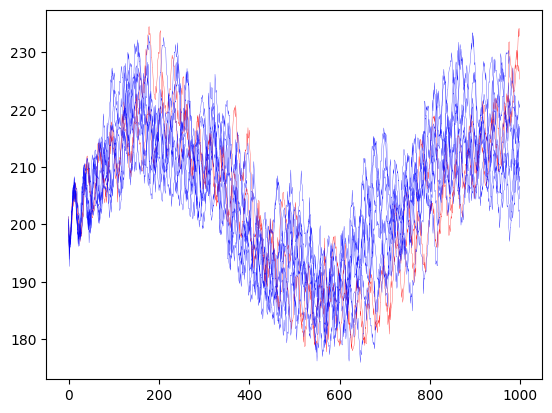

In [28]:
dg = DatasetGeneratorShift()
#10 data series a 1000 points with 20% outliers of severeness degree 1 (red), i.e., outlier phase shift ~ severeness
testCase2 = dg.generateKN(10, 1000, 0.2, severeness=2, verbose = True)

In [29]:
class DatasetGeneratorAmplitude(DatasetGenerator):
    """normal aplitude noise ~ N(0, ampl) """
    """outlier aplitude noise ~ N(0, ampl * (1+s)) """
    def getFunction(self, severeness):
        s = Sum()
        s.add_function(Line(200, 0))  # Add a Line function with offset 200 and slope 0
        s.add_function(RandomNoise(0, 1))  # Add a Random function 
        
        # Monthly, T1=720
        p1 = 30 + np.random.normal(0, 2, 1)
        a1 = 15 + 2 * severeness + np.random.normal(0, 2, 1)
        s.add_function(Period(p1 * 24, 0, a1))  # Add a Period function for monthly period
        
        # Weekly, T2=168
        p2 = 7 + np.random.normal(0, 1, 1)
        a2 = 10 + severeness + np.random.normal(0, 1, 1)
        s.add_function(PulseTrain(p2 * 24, 2 * 24, 24, a2))  # Add a PulseTrain function for weekly period

        # Daily, T3=24
        p3 = 1 + np.random.normal(0, 0.1 , 1)
        a3 = 5 + 0.1 * severeness + np.random.normal(0, 0.1 , 1)
        s.add_function(Period(p3 * 24, -6, a3))  # Add a Period function for daily period
        return s

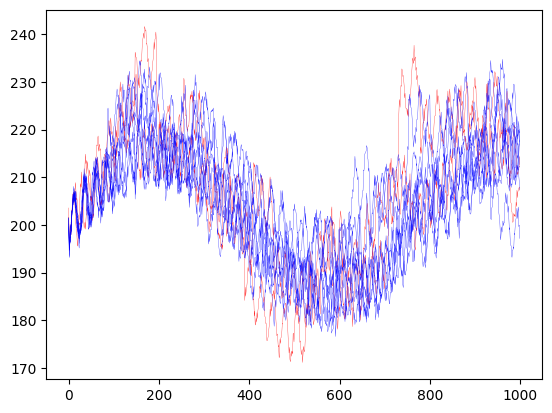

In [30]:
dg = DatasetGeneratorAmplitude()
#10 data series a 1000 points with 20% outliers of severeness degree 1 (red), i.e., outlier amplitude ~ severeness
testCase3 = dg.generateKN(10, 1000, 0.2, severeness=2, verbose = True)

In [31]:
class DatasetGeneratorSkip(DatasetGenerator):
    """normal: noise and all overlaying sine curves are added """
    """outlier: noise and some overlaying sine curves are skipped; more skips with increasing s"""
    def getFunction(self, severeness):
        s = Sum()
        if severeness < 1: #included in severeness 0 (normal)
            s.add_function(RandomNoise(0, 1))  # Add a Random function 
        
        if severeness < 2: #included in severeness 0, 1
            # Daily, T3=24
            p3 = 1 + np.random.normal(0, 0.1 , 1)
            a3 = 5 + np.random.normal(0, 0.1, 1)
            s.add_function(Period(p3 * 24, -6, a3))  # Add a Period function for daily period

        if severeness < 3: #included in severeness 0, 1, 2
            # Weekly, T2=168
            p2 = 7 + np.random.normal(0, 1, 1)
            a2 = 10 + np.random.normal(0, 1, 1)
            s.add_function(PulseTrain(p2 * 24, 2 * 24, 24, a2))  # Add a PulseTrain function for weekly period

        if severeness < 4: #included in severeness 0, 1, 2, 3, 
            # Monthly, T1=720
            p1 = 30 + np.random.normal(0, 2, 1)
            a1 = 15 + np.random.normal(0, 2, 1)
            s.add_function(Period(p1 * 24, 0, a1))  # Add a Period function for monthly period

        #included in all severeness levels 
        s.add_function(Line(200, 0))  # Add a Line function with offset 200 and slope 0

        return s

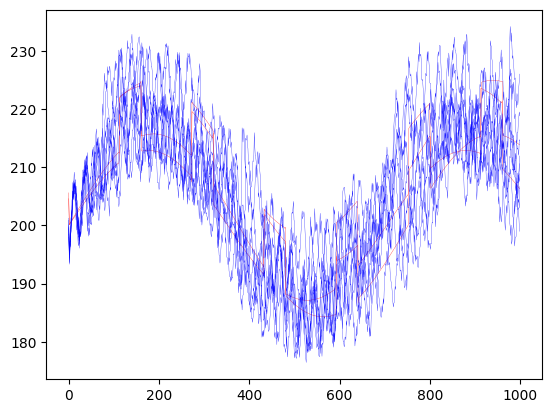

In [32]:
dg = DatasetGeneratorSkip()
#10 data series a 1000 points with 20% outliers of severeness degree 2 (red), i.e., outlier contain just weekly, monthly period and offset
testCase4 = dg.generateKN(10, 1000, 0.2, severeness=2, verbose = True)

In [33]:
class DatasetGeneratorSawtooth(DatasetGenerator):
    """outlier: some overlaying sine curves are replaced with sawtooth curves; more with increasing s"""
    def getFunction(self, severeness):
        s = Sum()
        
        p3 = 1 + np.random.normal(0, 0.1 , 1)
        a3 = 5 + np.random.normal(0, 0.1, 1)
        p2 = 7 + np.random.normal(0, 1, 1)
        a2 = 10 + np.random.normal(0, 1, 1)
        p1 = 30 + np.random.normal(0, 2, 1)
        a1 = 15 + np.random.normal(0, 2, 1)

        if severeness == 0: 
            # Daily, T3=24
            s.add_function(Period(p3 * 24, -6, a3))  # Add a Period function for daily period
            # Weekly, T2=168
            s.add_function(PulseTrain(p2 * 24, 2 * 24, 24, a2))  # Add a PulseTrain function for weekly period
            # Monthly, T1=720
            s.add_function(Period(p1 * 24, 0, a1))  # Add a Period function for monthly period
        elif severeness == 1: 
            # Daily, T3=24
            s.add_function(Sawtooth(p3 * 24, -6, a3))  # Add a Sawtooth function for daily period
            # Weekly, T2=168
            s.add_function(PulseTrain(p2 * 24, 2 * 24, 24, a2))  # Add a PulseTrain function for weekly period
            # Monthly, T1=720
            s.add_function(Period(p1 * 24, 0, a1))  # Add a Period function for monthly period
        elif severeness == 2: 
            # Daily, T3=24
            s.add_function(Period(p3 * 24, -6, a3))  # Add a Period function for daily period
            # Weekly, T2=168
            s.add_function(Sawtooth(p2 * 24, -12, a2))  # Add a Sawtooth function for weekly period
            # Monthly, T1=720
            s.add_function(Period(p1 * 24, 0, a1))  # Add a Period function for monthly period
        if severeness == 3: 
            # Daily, T3=24
            s.add_function(Period(p3 * 24, -6, a3))  # Add a Period function for daily period
            # Weekly, T2=168
            s.add_function(PulseTrain(p2 * 24, 2 * 24, 24, a2))  # Add a PulseTrain function for weekly period
            # Monthly, T1=720
            s.add_function(Sawtooth(p1 * 24, 0, a1))  # Add a Sawtooth function for monthly period
        elif severeness == 4: 
            # Daily, T3=24
            s.add_function(Sawtooth(p3 * 24, -6, a3))  # Add a Sawtooth function for daily period
            # Weekly, T2=168
            s.add_function(Sawtooth(p2 * 24, -12, a2))  # Add a Sawtooth function for weekly period
            # Monthly, T1=720
            s.add_function(Period(p1 * 24, 0, a1))  # Add a Period function for monthly period
        elif severeness == 4: 
            # Daily, T3=24
            s.add_function(Period(p3 * 24, -6, a3))  # Add a Sawtooth function for daily period
            # Weekly, T2=168
            s.add_function(Sawtooth(p2 * 24, -12, a2))  # Add a Sawtooth function for weekly period
            # Monthly, T1=720
            s.add_function(Sawtooth(p1 * 24, 0, a1))  # Add a Sawtooth function for monthly period
        elif severeness == 5: 
            # Daily, T3=24
            s.add_function(Sawtooth(p3 * 24, -6, a3))  # Add a Sawtooth function for daily period
            # Weekly, T2=168
            s.add_function(Sawtooth(p2 * 24, -12, a2))  # Add a Sawtooth function for weekly period
            # Monthly, T1=720
            s.add_function(Sawtooth(p1 * 24, 0, a1))  # Add a Sawtooth function for monthly period

        #included in all severeness levels 
        s.add_function(RandomNoise(0, 1))  # Add a Random function 
        s.add_function(Line(200, 0))  # Add a Line function with offset 200 and slope 0

        return s

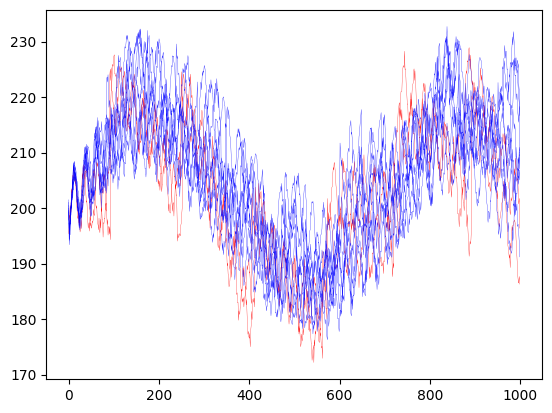

In [34]:
dg = DatasetGeneratorSawtooth()
#10 data series a 1000 points with 20% outliers of severeness degree 2 (red), i.e., outlier contain weekly sawtooth
testCase5 = dg.generateKN(10, 1000, 0.2, severeness=2, verbose = True)

In [35]:
class DatasetGeneratorBlackout(DatasetGenerator):
    """Generates data series each with blackouts increasing in number and depth with the given severeness."""
    def getFunction(self, severeness):
        # Orig function without offset
        s = Sum()
        s.add_function(RandomNoise(0, 1))  # Add a Random function 
        s.add_function(Line(50, 0))  # Add a Line function with offset 50 and slope 0
        
        # Monthly, T1=720
        p1 = 30 + np.random.normal(0, 2, 1)
        a1 = 15 + np.random.normal(0, 2, 1)
        s.add_function(Period(p1 * 24, 0, a1))  # Add a Period function for monthly period
        
        # Weekly, T2=168
        p2 = 7 + np.random.normal(0, 1, 1)
        a2 = 10 + np.random.normal(0, 1, 1)
        s.add_function(PulseTrain(p2 * 24, 2 * 24, 24, a2))  # Add a PulseTrain function for weekly period

        # Daily, T3=24
        p3 = 1 + np.random.normal(0, 0.1, 1)
        a3 = 5 + np.random.normal(0, 0.1, 1)
        s.add_function(Period(p3 * 24, -6, a3))  # Add a Period function for daily period
        
        #Blackout as a product function 
        p = Product()
        b = Sum()
        b.add_function(Line(1,0))  
        b.add_function(PulseTrain(T=N/(severeness+1), tau=10, phase=0, c=-0.1*severeness))  
        p.add_function(s)
        p.add_function(b)

        ss = Sum()
        ss.add_function(p)  # Add a Random function 
        ss.add_function(Line(150, 0))  # Add a Line function with offset 150 and slope 0

        return ss

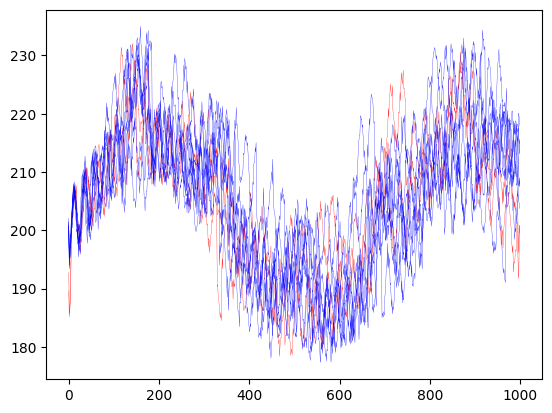

In [36]:
dg = DatasetGeneratorBlackout()
#10 data series a 1000 points with 20% outliers of severeness degree 2 (red), i.e., outlier contain "blackouts" for 10 time steps every 1000/(1+2) steps dropping values by 20% 
testCase6 = dg.generateKN(10, 1000, 0.2, severeness=2, verbose = True)

In [35]:
o=np.ones((10,2,1))
z=np.zeros((10,2,1))
np.mean(np.power(o - z, 1), axis=1)


array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])